[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/repos-especializacion-UdeA/trabajo-final_AA1/blob/main/notebooks_pasos_previos/00_preprocesamiento_dataset_clasificacion.ipynb)



# Preparación y preprocesamiento de datos del dataset Ninapro DB1

## Objetivo a desarrollar

> Obtener del dataset crudo los datos, combinarlos y realizar una transformación simple para hacerlos aptos para el entrenamiento de los modelos a emplear.

## 1. Librerias y configuraciones previas


In [1]:
# Verificacion de librerias necesarias antes de empezar
try:
    import scipy.io
    print("La librería 'scipy' está instalada y se ha importado correctamente.")
except ImportError:
    print("La librería 'scipy' no está instalada.")
    print("Instalando 'scipy'...")
    !pip install scipy

try:
    import libemg
    print("La librería 'libEMG' está instalada y se ha importado correctamente.")
except ImportError:
    print("La librería 'libEMG' no está instalada.")
    print("Instalando 'libEMG'...")
    !pip install libemg

try:
    import imblearn
    print("La librería 'imblearn' está instalada y se ha importado correctamente.")
except ImportError:
    print("La librería 'imblearn' no está instalada.")
    print("Instalando 'imblearn'...")
    !pip install imblearn

try:
    import mlflow
    print("La librería 'mlflow' está instalada y se ha importado correctamente.")
except ImportError:
    print("La librería 'mlflow' no está instalada.")
    print("Instalando 'mlflow'...")
    !pip install mlflow

La librería 'scipy' está instalada y se ha importado correctamente.
La librería 'libEMG' está instalada y se ha importado correctamente.
La librería 'imblearn' está instalada y se ha importado correctamente.
La librería 'mlflow' está instalada y se ha importado correctamente.


In [48]:
# Tratamiento de datos
# ==============================================================================
import pandas as pd
import numpy as np

# Almacenar en caché los resultados de funciones en el disco
# ==============================================================================
import joblib


# Gestion de librerias
# ==============================================================================
from importlib import reload

# Matemáticas y estadísticas
# ==============================================================================
import math

# Preparación de datos
# ==============================================================================
from imblearn.over_sampling import RandomOverSampler
from sklearn.neighbors import LocalOutlierFactor

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns


# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

# Formateo y estilo
# ==============================================================================
from IPython.display import Markdown, display

# Biblioteca scipy y componentes
# ==============================================================================
import scipy.io
from scipy import signal


In [49]:
import requests
from tqdm import tqdm
import os
import zipfile
import sys

In [4]:
from libemg.data_handler import OfflineDataHandler, RegexFilter
from libemg.utils import get_windows
from libemg.feature_extractor import FeatureExtractor

## 2. Funciones

In [5]:
#reload(utils.funciones)

# Funciones externas
# ==============================================================================
# from utils.funciones1 import multiple_plot
# from utils.funciones2 import test_hola, graficar_medida, graficar_medida2, filter_signal, \
#                             segmentar_data_base, aplanar_data_base, aplanar_ventana, \
#                             rms_value, mav_value, features_data_base

def find_value_ranges(arr, value):
    """
    Encuentra los rangos (inicio, fin) donde el valor dado aparece de forma continua en un array.

    Parámetros:
        arr (array-like): arreglo de entrada (lista o np.array).
        value (int o float): valor objetivo para encontrar bloques contiguos.

    Retorna:
        List[Tuple[int, int]]: lista de tuplas (inicio, fin) donde aparecen bloques del valor.
    """
    arr = np.asarray(arr)
    ranges = []
    in_range = False

    for i, val in enumerate(arr):
        if val == value and not in_range:
            start = i
            in_range = True
        elif val != value and in_range:
            end = i - 1
            ranges.append((start, end))
            in_range = False

    # Si termina en un bloque del valor
    if in_range:
        ranges.append((start, len(arr) - 1))

    return ranges

## 3. Carga y preprocesamiento del dataset original

Configuración inicial

In [6]:
# Agregar el directorio raíz del proyecto al PYTHONPATH
ROOT_DIR = os.path.abspath(os.path.join(os.getcwd(), '..'))  # Sube un nivel
if ROOT_DIR not in sys.path:
    sys.path.append(ROOT_DIR)
print(f"Directorio raíz del proyecto agregado al PYTHONPATH: {ROOT_DIR}")

Directorio raíz del proyecto agregado al PYTHONPATH: c:\Users\Usuario\Documents\UdeA\especializacion\repos\monografia


In [7]:
# se importan las rutas
# from globals import SRC_DIR, DATA_DIR, RAW_DATA_DIR, PROCESSED_DATA_DIR
# Agregar el directorio SRC_DIR al PYTHONPATH
#if SRC_DIR not in sys.path:
#    sys.path.append(SRC_DIR)
from globals import RAW_SUBSET_DATA_DIR
print(f"Ruta de subconjunto de datos crudos: {RAW_SUBSET_DATA_DIR}")

Ruta de subconjunto de datos crudos: c:\Users\Usuario\Documents\UdeA\especializacion\repos\monografia\data\raw_subset


### Formato del archivo

Con el fin de conocer un poco lo que contiene un solo MAT vamos a realizar los siguientes procedimientos.

En nuestro analisis, solo nos va a interesar los datos de las columnas:
* **`emg`**: Señales EMG superficiales tomadas de los 10 electronos.
* **`rerepetition`**: Repetición de la postura de la mano (ejercicio) realizado. Cada postura se repetira 10 veces.
* **`restimulus`**: Postura manual (ejercicio) realizada.

### Carga de datos

### Combinación de los archivos

In [8]:
# Listar y cargar los archivos .npy del directorio PROCESSED_DATA_DIR
npy_files = [f for f in os.listdir(RAW_SUBSET_DATA_DIR) if f.endswith('.npy')]

raw_data = {}
for file in npy_files:
    file_path = os.path.join(RAW_SUBSET_DATA_DIR, file)
    sub_i = file.split('_s')[-1].split('.')[0]
    sub_i = sub_i.split('_')[0]
    raw_data[sub_i] = np.load(file_path)
    print(f"Archivo cargado: {file}")

Archivo cargado: raw_subset_s10_p1_23_E3.npy
Archivo cargado: raw_subset_s11_p1_23_E3.npy
Archivo cargado: raw_subset_s12_p1_23_E3.npy
Archivo cargado: raw_subset_s13_p1_23_E3.npy
Archivo cargado: raw_subset_s14_p1_23_E3.npy
Archivo cargado: raw_subset_s15_p1_23_E3.npy
Archivo cargado: raw_subset_s16_p1_23_E3.npy
Archivo cargado: raw_subset_s17_p1_23_E3.npy
Archivo cargado: raw_subset_s18_p1_23_E3.npy
Archivo cargado: raw_subset_s19_p1_23_E3.npy
Archivo cargado: raw_subset_s1_p1_23_E3.npy
Archivo cargado: raw_subset_s20_p1_23_E3.npy
Archivo cargado: raw_subset_s21_p1_23_E3.npy
Archivo cargado: raw_subset_s22_p1_23_E3.npy
Archivo cargado: raw_subset_s23_p1_23_E3.npy
Archivo cargado: raw_subset_s24_p1_23_E3.npy
Archivo cargado: raw_subset_s25_p1_23_E3.npy
Archivo cargado: raw_subset_s26_p1_23_E3.npy
Archivo cargado: raw_subset_s27_p1_23_E3.npy
Archivo cargado: raw_subset_s2_p1_23_E3.npy
Archivo cargado: raw_subset_s3_p1_23_E3.npy
Archivo cargado: raw_subset_s4_p1_23_E3.npy
Archivo cargad

In [9]:
len(raw_data)  # Mostrar la cantidad de archivos cargados

27

In [10]:
raw_data['1'].shape

(16036, 12)

### Usuario de muestra

Nuevamente usemos el usuario de muestra 1 (indice = 0)

```
[ emg | restimulus | rerepetition ] = [ 0:9 | 10 | 11 ]
```

* **`restimulus`**: 1 - 23 (El reposo se toma como 0)
* **`rerepetition`**: 1 - 10

In [11]:
INDEX_SUB = '1'
emg_s1 = raw_data[INDEX_SUB][:,0:10]
restimulus_s1 = raw_data[INDEX_SUB][:,10]
rerepetition_s1 = raw_data[INDEX_SUB][:,11]

Vamos a graficar todas los ejercicios para el usuario seleccionado

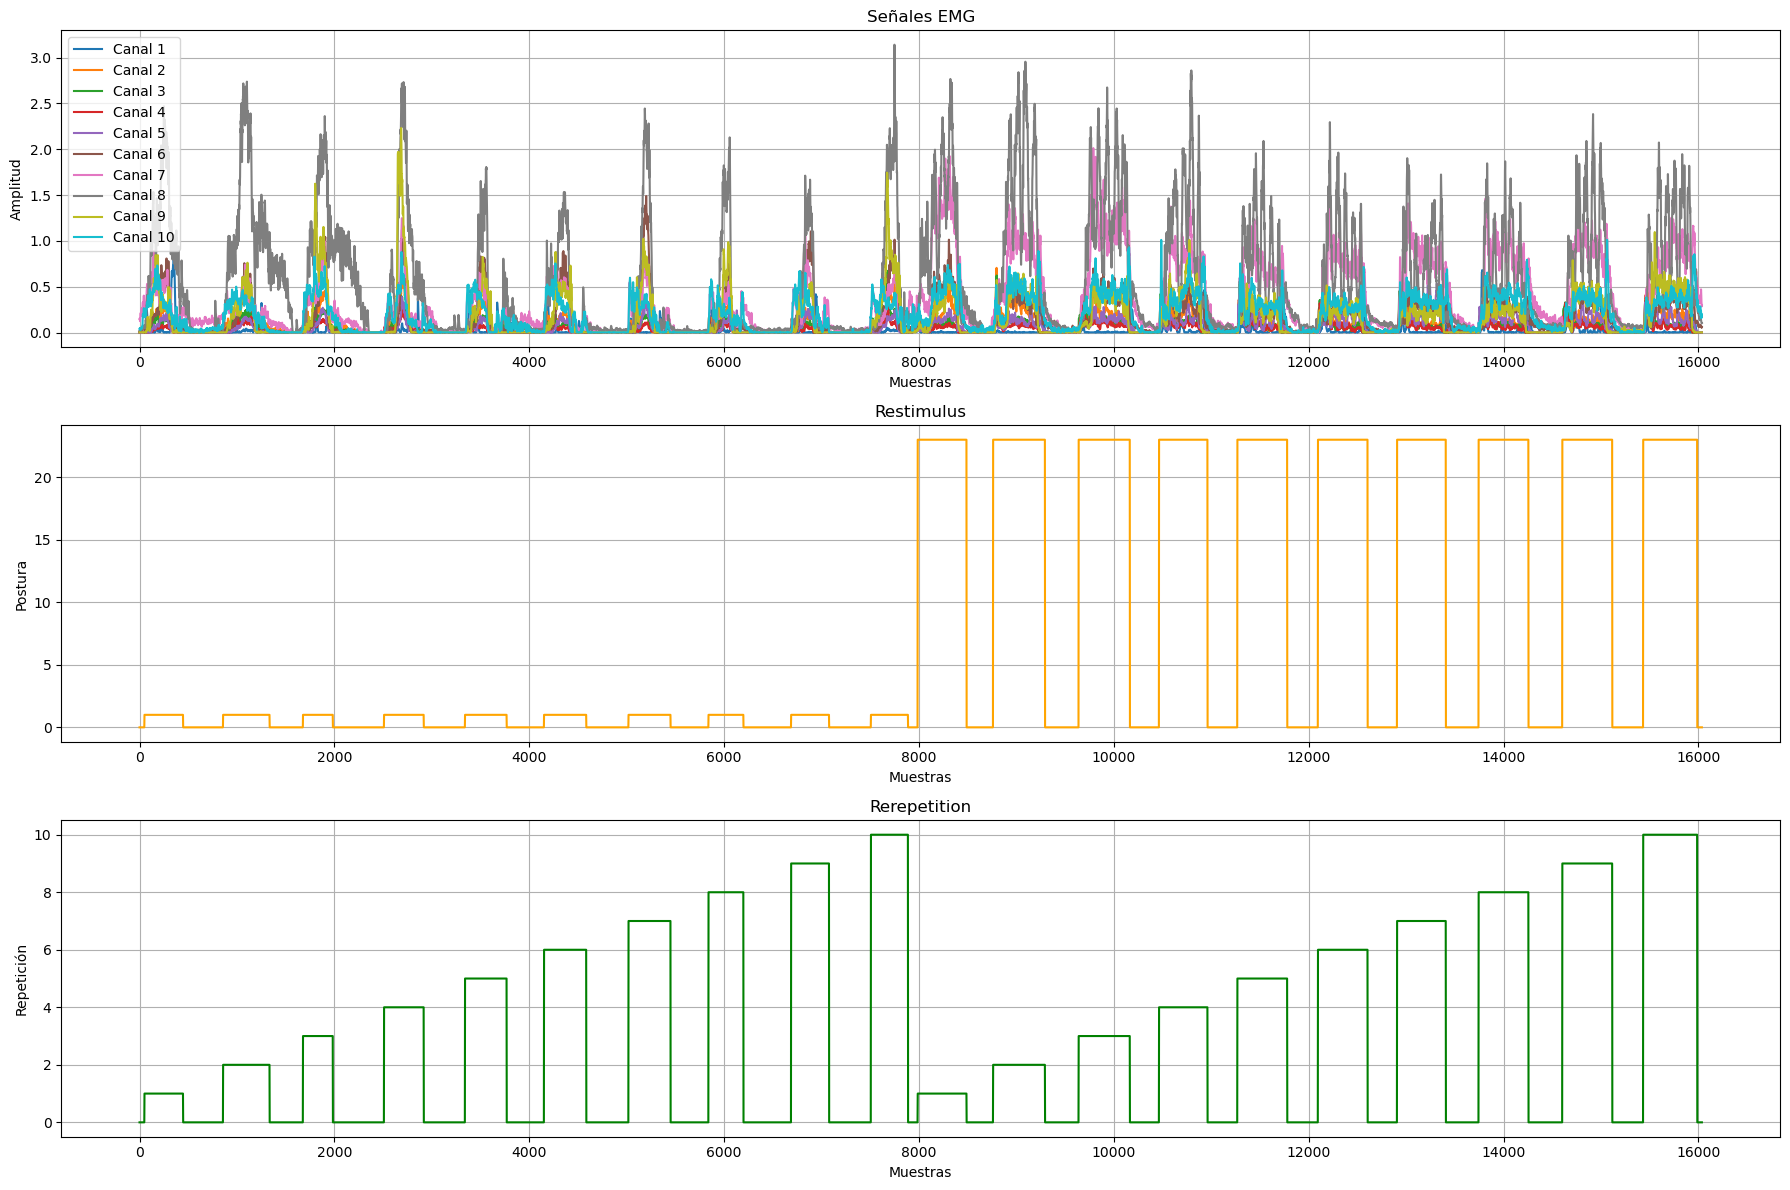

In [12]:
plt.figure(figsize=(18, 12))

# Subplot 1: EMG signals
plt.subplot(3, 1, 1)
for i in range(emg_s1.shape[1]):  # Iterate over each EMG channel
    plt.plot(emg_s1[:, i], label=f'Canal {i+1}')
plt.title('Señales EMG')
plt.xlabel('Muestras')
plt.ylabel('Amplitud')
plt.legend()
plt.grid(True)

# Subplot 2: Restimulus
plt.subplot(3, 1, 2)
plt.plot(restimulus_s1, color='orange')
plt.title('Restimulus')
plt.xlabel('Muestras')
plt.ylabel('Postura')
plt.grid(True)

# Subplot 3: Rerepetition
plt.subplot(3, 1, 3)
plt.plot(rerepetition_s1, color='green')
plt.title('Rerepetition')
plt.xlabel('Muestras')
plt.ylabel('Repetición')
plt.grid(True)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

In [13]:
raw_data[INDEX_SUB].shape  # Mostrar la forma de los datos cargados

(16036, 12)

### EDA basico

Funcion que concatena los datos de todos los usuarios

In [27]:
def concatenar_matrices_con_clave(diccionario_matrices):
    """
    Concatena verticalmente las matrices en un diccionario, 
    agregando una columna a la izquierda con el valor entero de la clave asociada a cada matriz.

    Parámetros:
    diccionario_matrices (dict): Diccionario cuyas claves son cadenas de dígitos ('1', '2', ...) 
                                  y cuyos valores son matrices numpy de igual número de columnas.

    Retorna:
    numpy.ndarray: Una única matriz numpy con una columna adicional al principio que identifica la clave original.
    """
    matrices_modificadas = []

    for k, matriz in diccionario_matrices.items():
        clave_int = int(k)
        n_filas = matriz.shape[0]
        columna_clave = np.full((n_filas, 1), clave_int)
        matriz_modificada = np.hstack((columna_clave, matriz))
        matrices_modificadas.append(matriz_modificada)

    return np.concatenate(matrices_modificadas, axis=0)

Invocación de la función

In [28]:
all_users_raw_data = concatenar_matrices_con_clave(raw_data)
all_users_raw_data.shape  # Mostrar la forma de los datos concatenados

(432383, 13)

Creación del dataframe

In [29]:
# Crear un DataFrame a partir de all_users_raw_data
columns = ['subject'] + [f'emg_{i}' for i in range(1, 11)] + ['restimulus', 'rerepetition']
df_all_users = pd.DataFrame(all_users_raw_data, columns=columns)

# Mostrar las primeras filas del DataFrame
df_all_users.head()

subject   emg_1   emg_2   emg_3   emg_4   emg_5   emg_6   emg_7   emg_8  \
0     10.0  0.2686  0.1196  0.0024  0.0024  0.0024  0.0024  0.0024  0.0098   
1     10.0  0.2588  0.1074  0.0024  0.0024  0.0024  0.0024  0.0024  0.0098   
2     10.0  0.2319  0.0879  0.0024  0.0024  0.0024  0.0024  0.0024  0.0073   
3     10.0  0.2075  0.0684  0.0024  0.0024  0.0024  0.0024  0.0024  0.0024   
4     10.0  0.1807  0.0562  0.0024  0.0024  0.0024  0.0024  0.0024  0.0024   

    emg_9  emg_10  restimulus  rerepetition  
0  0.0024  0.0024         0.0           0.0  
1  0.0024  0.0024         0.0           0.0  
2  0.0024  0.0024         0.0           0.0  
3  0.0024  0.0024         0.0           0.0  
4  0.0024  0.0024         0.0           0.0

Tamaño

In [32]:
df_all_users.shape  # Mostrar la forma de los datos concatenados

(432383, 13)

In [33]:
df_all_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 432383 entries, 0 to 432382
Data columns (total 13 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   subject       432383 non-null  float64
 1   emg_1         432383 non-null  float64
 2   emg_2         432383 non-null  float64
 3   emg_3         432383 non-null  float64
 4   emg_4         432383 non-null  float64
 5   emg_5         432383 non-null  float64
 6   emg_6         432383 non-null  float64
 7   emg_7         432383 non-null  float64
 8   emg_8         432383 non-null  float64
 9   emg_9         432383 non-null  float64
 10  emg_10        432383 non-null  float64
 11  restimulus    432383 non-null  float64
 12  rerepetition  432383 non-null  float64
dtypes: float64(13)
memory usage: 42.9 MB


In [34]:
# Convertir las columnas en categóricas
df_all_users['subject'] = df_all_users['subject'].astype('category')
df_all_users['restimulus'] = df_all_users['restimulus'].astype('category')
df_all_users['rerepetition'] = df_all_users['rerepetition'].astype('category')

# Verificar los cambios
df_all_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 432383 entries, 0 to 432382
Data columns (total 13 columns):
 #   Column        Non-Null Count   Dtype   
---  ------        --------------   -----   
 0   subject       432383 non-null  category
 1   emg_1         432383 non-null  float64 
 2   emg_2         432383 non-null  float64 
 3   emg_3         432383 non-null  float64 
 4   emg_4         432383 non-null  float64 
 5   emg_5         432383 non-null  float64 
 6   emg_6         432383 non-null  float64 
 7   emg_7         432383 non-null  float64 
 8   emg_8         432383 non-null  float64 
 9   emg_9         432383 non-null  float64 
 10  emg_10        432383 non-null  float64 
 11  restimulus    432383 non-null  category
 12  rerepetition  432383 non-null  category
dtypes: category(3), float64(10)
memory usage: 34.2 MB


In [36]:
df_all_users.describe(include='category')

subject  restimulus  rerepetition
count   432383.0    432383.0      432383.0
unique      27.0         3.0          11.0
top          5.0         0.0           0.0
freq     16154.0    212160.0      212160.0

In [37]:
df_all_users.describe()

emg_1          emg_2          emg_3          emg_4  \
count  432383.000000  432383.000000  432383.000000  432383.000000   
mean        0.324271       0.186015       0.147283       0.069166   
std         0.489780       0.308283       0.273587       0.202291   
min         0.002400       0.000000       0.002400       0.002400   
25%         0.004900       0.002400       0.002400       0.002400   
50%         0.087900       0.034200       0.004900       0.002400   
75%         0.451700       0.266100       0.178200       0.051300   
max         4.668000       4.663100       3.186000       4.665500   

               emg_5          emg_6          emg_7          emg_8  \
count  432383.000000  432383.000000  432383.000000  432383.000000   
mean        0.033424       0.108512       0.383935       0.478763   
std         0.072883       0.258764       0.561192       0.581069   
min         0.002400       0.000000       0.002400       0.000000   
25%         0.002400       0.002400       0.043900       0.073200   
50%         0.002400       0.026900       0.173300       0.251500   
75%         0.029300       0.107400       0.490700       0.690900   
max         1.486800       4.221200       4.665500       4.665500   

               emg_9         emg_10  
count  432383.000000  432383.000000  
mean        0.149363       0.252905  
std         0.290785       0.392493  
min         0.000000       0.002400  
25%         0.002400       0.031700  
50%         0.017100       0.127000  
75%         0.175800       0.307600  
max         4.636200       4.655800

In [46]:
# Listar valores únicos y su cantidad para las columnas categóricas, ordenados
categorical_columns = ['subject', 'restimulus', 'rerepetition']

for column in categorical_columns:
    print(f"Valores únicos y su cantidad para la columna '{column}' (ordenados):")
    print(df_all_users[column].value_counts().sort_index())
    print("\n")

Valores únicos y su cantidad para la columna 'subject' (ordenados):
subject
1.0     16036
2.0     15973
3.0     15956
4.0     16000
5.0     16154
6.0     16069
7.0     15955
8.0     16056
9.0     16120
10.0    15988
11.0    16099
12.0    15930
13.0    16007
14.0    15864
15.0    15937
16.0    16001
17.0    16034
18.0    15985
19.0    16116
20.0    15972
21.0    16109
22.0    16003
23.0    15901
24.0    16055
25.0    16013
26.0    16150
27.0    15900
Name: count, dtype: int64


Valores únicos y su cantidad para la columna 'restimulus' (ordenados):
restimulus
0.0     212160
1.0      96108
23.0    124115
Name: count, dtype: int64


Valores únicos y su cantidad para la columna 'rerepetition' (ordenados):
rerepetition
0.0     212160
1.0      21965
2.0      21704
3.0      21916
4.0      21418
5.0      21962
6.0      22416
7.0      22148
8.0      22330
9.0      22529
10.0     21835
Name: count, dtype: int64




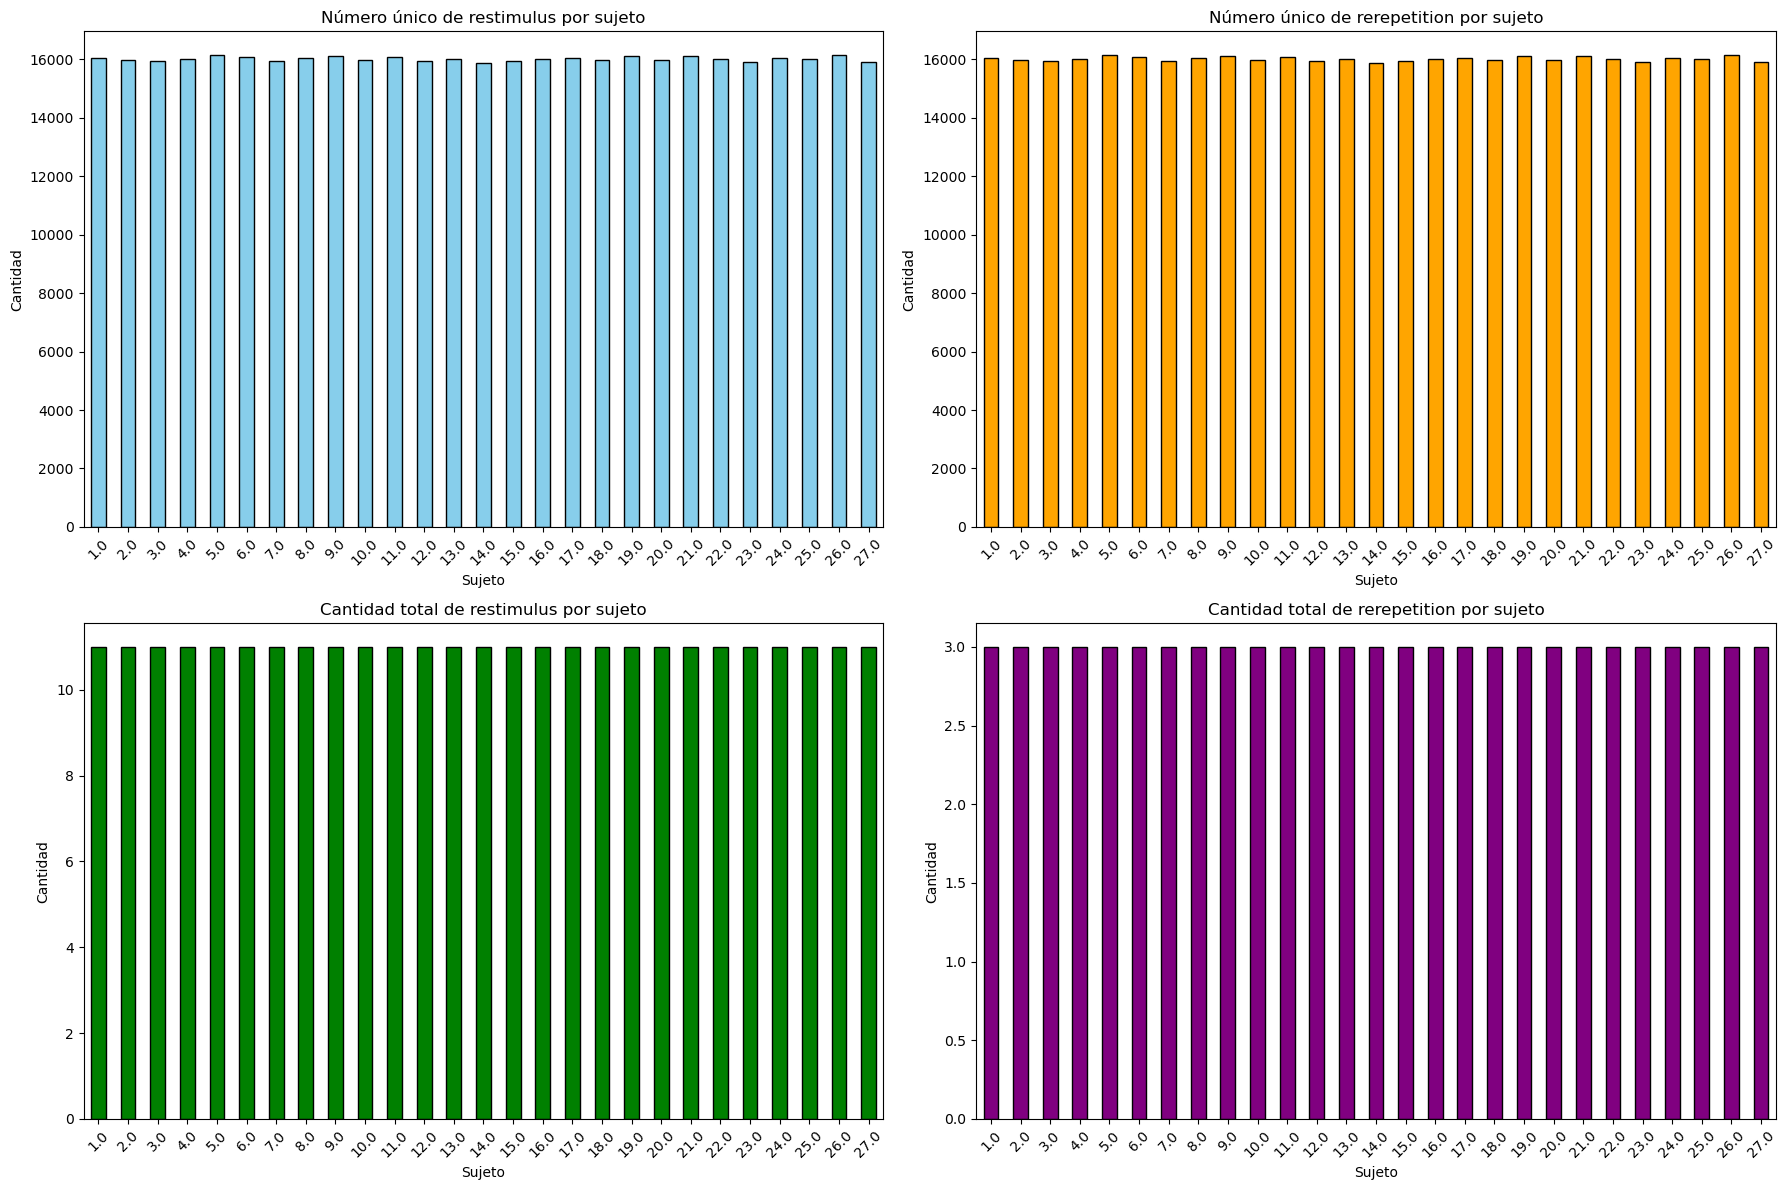

In [51]:
# Configuración de estilo para las gráficas
# plt.style.use('seaborn-darkgrid')
plt.figure(figsize=(18, 12))

# Gráfica 1: Número único de restimulus por sujeto
plt.subplot(2, 2, 1)
pivot_table['unique_restimulus'].plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Número único de restimulus por sujeto')
plt.xlabel('Sujeto')
plt.ylabel('Cantidad')
plt.xticks(rotation=45)

# Gráfica 2: Número único de rerepetition por sujeto
plt.subplot(2, 2, 2)
pivot_table['unique_rerepetition'].plot(kind='bar', color='orange', edgecolor='black')
plt.title('Número único de rerepetition por sujeto')
plt.xlabel('Sujeto')
plt.ylabel('Cantidad')
plt.xticks(rotation=45)

# Gráfica 3: Cantidad total de restimulus por sujeto
plt.subplot(2, 2, 3)
pivot_table['count_restimulus'].plot(kind='bar', color='green', edgecolor='black')
plt.title('Cantidad total de restimulus por sujeto')
plt.xlabel('Sujeto')
plt.ylabel('Cantidad')
plt.xticks(rotation=45)

# Gráfica 4: Cantidad total de rerepetition por sujeto
plt.subplot(2, 2, 4)
pivot_table['count_rerepetition'].plot(kind='bar', color='purple', edgecolor='black')
plt.title('Cantidad total de rerepetition por sujeto')
plt.xlabel('Sujeto')
plt.ylabel('Cantidad')
plt.xticks(rotation=45)

# Ajustar el diseño y mostrar las gráficas
plt.tight_layout()
plt.show()

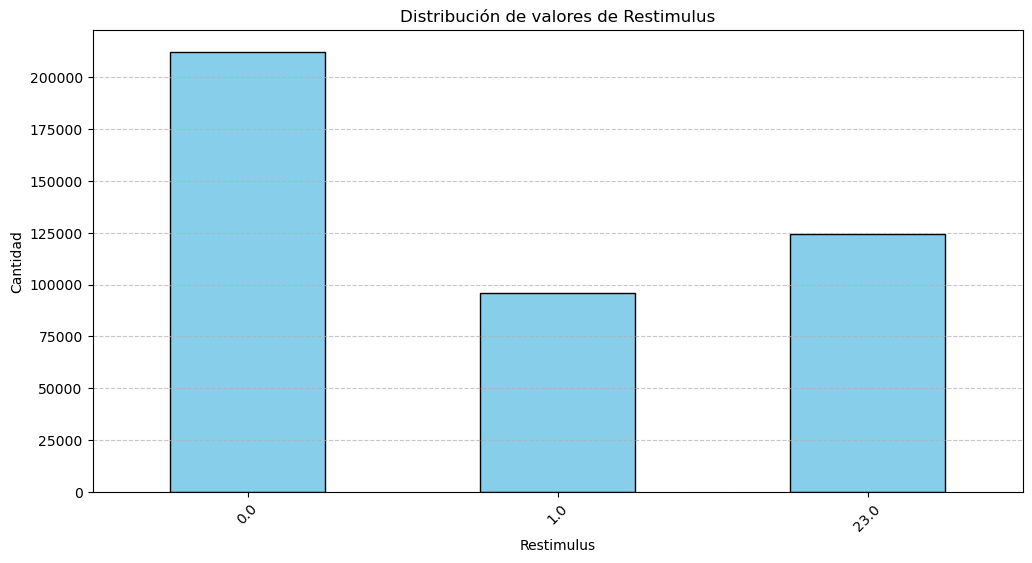

In [52]:
# Contar las ocurrencias de cada valor de restimulus
restimulus_counts = df_all_users['restimulus'].value_counts().sort_index()

# Crear la gráfica de barras
plt.figure(figsize=(12, 6))
restimulus_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Distribución de valores de Restimulus')
plt.xlabel('Restimulus')
plt.ylabel('Cantidad')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [54]:
# Crear una figura para la gráfica
plt.figure(figsize=(12, 18))

# Iterar sobre cada usuario y graficar sus valores de restimulus
for i, subject in enumerate(df_all_users['subject'].cat.categories, start=1):
    plt.subplot(9, 3, i)  # Crear subplots en una cuadrícula de 9x3
    user_data = df_all_users[df_all_users['subject'] == subject]
    restimulus_counts = user_data['restimulus'].value_counts().sort_index()
    restimulus_counts.plot(kind='barh', color='skyblue', edgecolor='black')
    plt.title(f'Sujeto {int(subject)}')
    plt.xlabel('Cantidad')
    plt.ylabel('Restimulus')
    plt.tight_layout()

# Mostrar la gráfica
plt.show()

In [55]:
# Crear una tabla pivote para describir las variables categóricas por sujeto
pivot_table = df_all_users.pivot_table(
    values=['restimulus', 'rerepetition'], 
    index='subject', 
    aggfunc={'restimulus': ['nunique', 'count'], 'rerepetition': ['nunique', 'count']}
)

# Renombrar las columnas para mayor claridad
pivot_table.columns = ['unique_restimulus', 'count_restimulus', 'unique_rerepetition', 'count_rerepetition']

# Mostrar la tabla pivote
pivot_table

unique_restimulus  count_restimulus  unique_rerepetition  \
subject                                                             
1.0                  16036                11                16036   
2.0                  15973                11                15973   
3.0                  15956                11                15956   
4.0                  16000                11                16000   
5.0                  16154                11                16154   
6.0                  16069                11                16069   
7.0                  15955                11                15955   
8.0                  16056                11                16056   
9.0                  16120                11                16120   
10.0                 15988                11                15988   
11.0                 16099                11                16099   
12.0                 15930                11                15930   
13.0                 16007                11                16007   
14.0                 15864                11                15864   
15.0                 15937                11                15937   
16.0                 16001                11                16001   
17.0                 16034                11                16034   
18.0                 15985                11                15985   
19.0                 16116                11                16116   
20.0                 15972                11                15972   
21.0                 16109                11                16109   
22.0                 16003                11                16003   
23.0                 15901                11                15901   
24.0                 16055                11                16055   
25.0                 16013                11                16013   
26.0                 16150                11                16150   
27.0                 15900                11                15900   

         count_rerepetition  
subject                      
1.0                       3  
2.0                       3  
3.0                       3  
4.0                       3  
5.0                       3  
6.0                       3  
7.0                       3  
8.0                       3  
9.0                       3  
10.0                      3  
11.0                      3  
12.0                      3  
13.0                      3  
14.0                      3  
15.0                      3  
16.0                      3  
17.0                      3  
18.0                      3  
19.0                      3  
20.0                      3  
21.0                      3  
22.0                      3  
23.0                      3  
24.0                      3  
25.0                      3  
26.0                      3  
27.0                      3

In [56]:
# Crear una tabla pivote para describir las estadísticas de las variables numéricas por sujeto
pivot_table_numerical = df_all_users.pivot_table(
    values=numerical_columns,
    index='subject',
    aggfunc=['mean', 'std', 'min', 'max']
)

# Renombrar las columnas para mayor claridad
pivot_table_numerical.columns = ['_'.join(col).strip() for col in pivot_table_numerical.columns.values]

# Mostrar la tabla pivote
pivot_table_numerical

mean_emg_1  mean_emg_10  mean_emg_2  mean_emg_3  mean_emg_4  \
subject                                                                
1.0        0.022233     0.193644    0.082705    0.057918    0.038363   
2.0        0.033565     0.475930    0.147554    0.393143    0.299906   
3.0        0.388398     0.098341    0.182102    0.130512    0.014554   
4.0        0.079882     0.202026    0.163344    0.043576    0.003125   
5.0        0.771450     0.260932    0.231249    0.138002    0.113475   
6.0        0.557960     0.227165    0.147324    0.143317    0.030566   
7.0        0.255176     0.149943    0.061716    0.042019    0.010244   
8.0        0.194948     0.175256    0.198370    0.142751    0.067447   
9.0        0.654781     0.145059    0.134832    0.129329    0.080840   
10.0       0.516517     0.123169    0.160556    0.076370    0.053448   
11.0       0.186801     0.058994    0.164789    0.164789    0.037370   
12.0       0.656532     0.352877    0.184214    0.191137    0.082803   
13.0       0.237805     0.564895    0.184659    0.142406    0.052214   
14.0       0.158216     0.192071    0.073371    0.043216    0.018421   
15.0       0.500618     0.326677    0.180060    0.083933    0.013420   
16.0       0.473778     0.338596    0.363928    0.294878    0.095246   
17.0       0.315610     0.217645    0.171316    0.102939    0.044560   
18.0       0.580292     0.342291    0.132863    0.172663    0.053145   
19.0       0.539083     0.104653    0.217422    0.231803    0.047532   
20.0       0.705634     0.476626    0.499643    0.212133    0.126305   
21.0       0.315189     0.108195    0.143832    0.095275    0.034449   
22.0       0.552730     0.105417    0.086483    0.179715    0.017337   
23.0       0.003203     0.266687    0.447552    0.262893    0.307674   
24.0       0.004929     0.363960    0.172084    0.224281    0.103616   
25.0       0.033544     0.479039    0.360453    0.123543    0.072313   
26.0       0.007143     0.204665    0.080947    0.045939    0.031497   
27.0       0.003590     0.278531    0.050298    0.108723    0.018952   

         mean_emg_5  mean_emg_6  mean_emg_7  mean_emg_8  mean_emg_9  ...  \
subject                                                              ...   
1.0        0.060022    0.150317    0.365170    0.551302    0.154675  ...   
2.0        0.023406    0.069626    0.715677    0.598440    0.277907  ...   
3.0        0.003758    0.008078    0.137498    0.407650    0.023263  ...   
4.0        0.008036    0.083761    0.479546    0.417559    0.036023  ...   
5.0        0.051097    0.086167    0.314002    0.347909    0.094954  ...   
6.0        0.026416    0.095169    0.427962    0.693491    0.122717  ...   
7.0        0.005301    0.019324    0.216086    0.455685    0.032344  ...   
8.0        0.014720    0.062190    0.324006    0.277823    0.156777  ...   
9.0        0.025075    0.085767    0.221426    0.514638    0.159175  ...   
10.0       0.003856    0.008814    0.157218    0.209197    0.047702  ...   
11.0       0.022908    0.018354    0.265324    0.449032    0.171216  ...   
12.0       0.036583    0.091474    0.401878    0.520489    0.212913  ...   
13.0       0.015574    0.055243    0.412522    0.334322    0.066135  ...   
14.0       0.067410    0.315618    0.294360    0.230665    0.090755  ...   
15.0       0.010314    0.041764    0.509177    0.484407    0.076645  ...   
16.0       0.056030    0.102120    0.505034    0.369184    0.256999  ...   
17.0       0.017209    0.067335    0.413152    0.586184    0.110885  ...   
18.0       0.017426    0.083208    0.591986    0.724614    0.082480  ...   
19.0       0.016148    0.015247    0.229861    0.381478    0.151654  ...   
20.0       0.042871    0.023304    0.103973    0.525677    0.271244  ...   
21.0       0.013214    0.027923    0.257686    0.413648    0.189236  ...   
22.0       0.009091    0.054551    0.157296    0.301501    0.097889  ...   
23.0       0.091971    0.102392    0.565514    0.635858    0.186928  ...   
24.0       0.101907 

In [57]:
# Crear histogramas para cada canal EMG
plt.figure(figsize=(20, 15))

for i, column in enumerate(numerical_columns, start=1):
    plt.subplot(4, 3, i)  # Crear subplots en una cuadrícula de 4x3
    df_all_users[column].hist(bins=50, color='skyblue', edgecolor='black')
    plt.title(f'Histograma de {column}')
    plt.xlabel('Valor')
    plt.ylabel('Frecuencia')

plt.tight_layout()
plt.show()

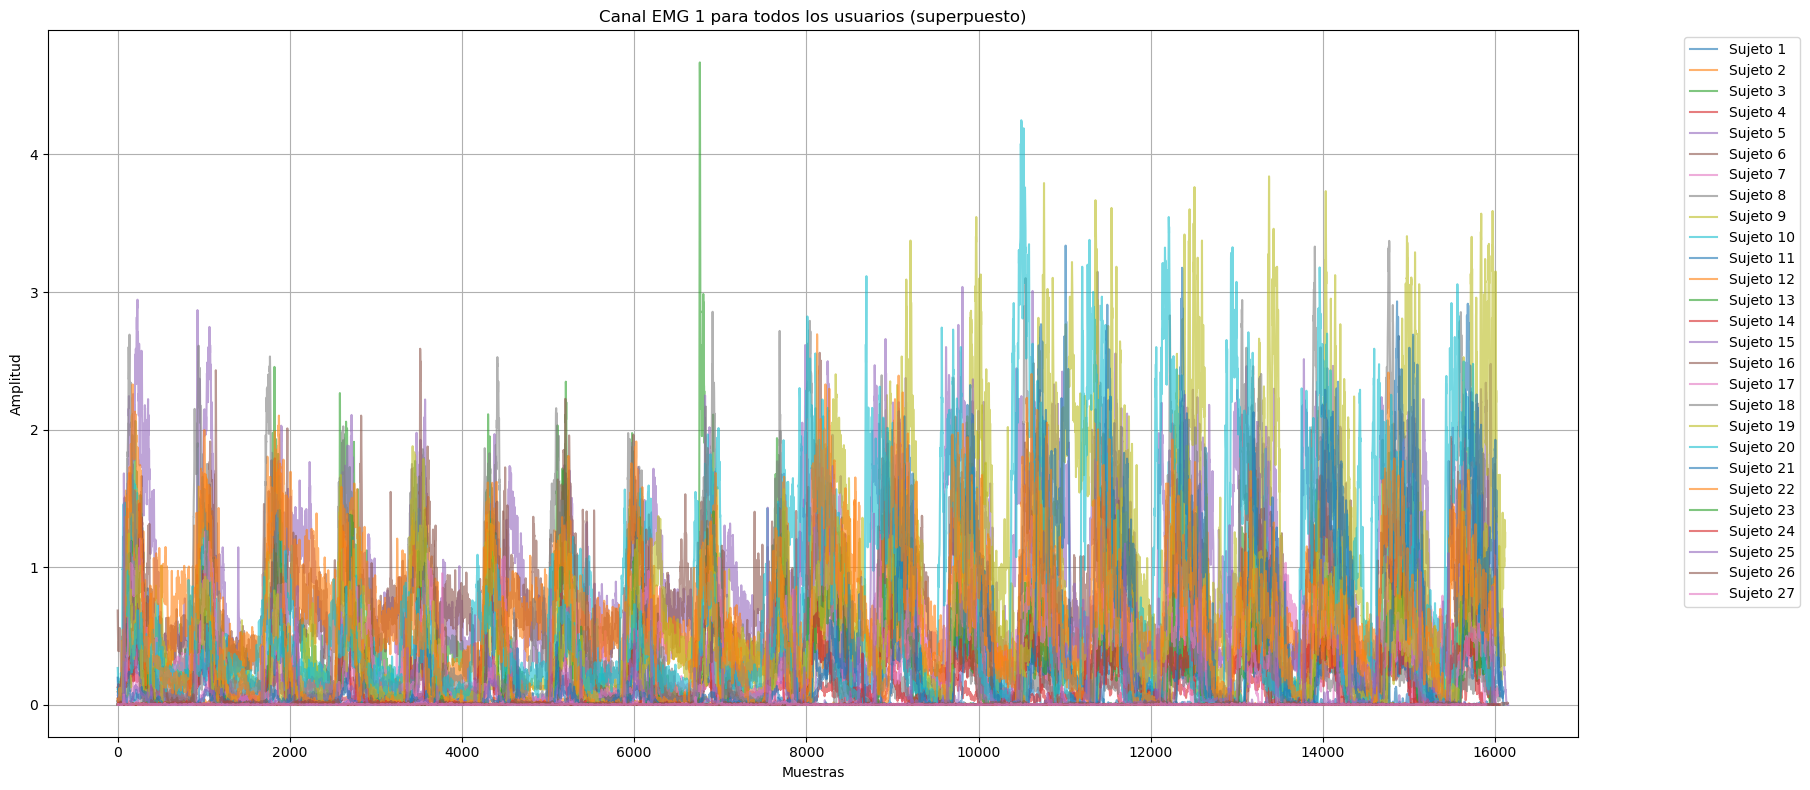

In [61]:
plt.figure(figsize=(18, 8))

# Iterar sobre cada usuario y graficar el canal 1
for subject in df_all_users['subject'].cat.categories:
    user_data = df_all_users[df_all_users['subject'] == subject]
    plt.plot(user_data['emg_1'].reset_index(drop=True), alpha=0.6, label=f'Sujeto {int(subject)}')  # Usar alpha para transparencia

plt.title('Canal EMG 1 para todos los usuarios (superpuesto)')
plt.xlabel('Muestras')
plt.ylabel('Amplitud')
plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1), ncol=1)
plt.grid(True)
plt.tight_layout()
plt.show()

In [65]:
# Configuración de la figura
plt.figure(figsize=(12, len(df_all_users['subject'].cat.categories) * 5))  # Ajustar la altura para mayor claridad

# Iterar sobre cada sujeto y graficar sus señales EMG
for i, subject in enumerate(df_all_users['subject'].cat.categories, start=1):
    plt.subplot(len(df_all_users['subject'].cat.categories), 1, i)  # Crear subplots en una sola columna
    user_data = df_all_users[df_all_users['subject'] == subject]
    for emg_column in numerical_columns:  # Graficar cada canal EMG
        plt.plot(user_data[emg_column].reset_index(drop=True), alpha=0.6, label=emg_column)
    plt.title(f'Sujeto {int(subject)}')
    plt.xlabel('Muestras')
    plt.ylabel('Amplitud')
    plt.legend(loc='upper right', fontsize='small')
    plt.grid(True)

# Ajustar el diseño y mostrar las gráficas
plt.tight_layout()
plt.show()

#### Postura 1

#### Aplicación del procedimiento para todos los sujetos 

In [48]:
selected_exercises = [1, 23]  # Ejercicios seleccionados
data_for_selected_exercises = []
for subject in range(len(data)):
    data_for_selected_exercises.append(get_samples_by_exercises(data[subject], selected_exercises))
    # Obtener muestras de los ejercicios seleccionados para cada sujeto
    print(f"Sujeto {subject + 1}: {data_for_selected_exercises[subject].shape} muestras obtenidas para los ejercicios {selected_exercises}")

Sujeto 1: (16036, 12) muestras obtenidas para los ejercicios [1, 23]
Sujeto 2: (15988, 12) muestras obtenidas para los ejercicios [1, 23]
Sujeto 3: (16099, 12) muestras obtenidas para los ejercicios [1, 23]
Sujeto 4: (15930, 12) muestras obtenidas para los ejercicios [1, 23]
Sujeto 5: (16007, 12) muestras obtenidas para los ejercicios [1, 23]
Sujeto 6: (15864, 12) muestras obtenidas para los ejercicios [1, 23]
Sujeto 7: (15937, 12) muestras obtenidas para los ejercicios [1, 23]
Sujeto 8: (16001, 12) muestras obtenidas para los ejercicios [1, 23]
Sujeto 9: (16034, 12) muestras obtenidas para los ejercicios [1, 23]
Sujeto 10: (15985, 12) muestras obtenidas para los ejercicios [1, 23]
Sujeto 11: (16116, 12) muestras obtenidas para los ejercicios [1, 23]
Sujeto 12: (15973, 12) muestras obtenidas para los ejercicios [1, 23]
Sujeto 13: (15972, 12) muestras obtenidas para los ejercicios [1, 23]
Sujeto 14: (16109, 12) muestras obtenidas para los ejercicios [1, 23]
Sujeto 15: (16003, 12) muestr

In [49]:
len(data_for_selected_exercises)

27

In [50]:
data_for_selected_exercises[0].shape  # Mostrar la forma de los datos del primer sujeto

(16036, 12)

## Almacenamiento de los datos crudos a analizar

Los datos crudos a analizar se almacenarán en el directorio **`RAW_SUBSET_DATA_DIR`** siguiendo la nomenclatura `raw_subset_s{x}_p{1_2_*}_E3.npy`. Donde:
* **`s_{x}`**: Numero del sujeto.
* **`p_{nums}`**: Numero de las posturas seleccionadas.
* **`E3`**: Por que las posturas que se usan son las asociadas al ejercicio 3.

**Nota**: Se sobreentiende que la postura 0 va pues es asociada a la posición de descanso.

In [51]:
RAW_SUBSET_DATA_DIR

'c:\\Users\\Usuario\\Documents\\UdeA\\especializacion\\repos\\monografia\\data\\raw_subset'

In [52]:
selected_exercises

[1, 23]

In [53]:
# Crear el directorio si no existe
os.makedirs(RAW_SUBSET_DATA_DIR, exist_ok=True)

# Almacenar cada np.array en un archivo .npy
for idx, subject_data in enumerate(data_for_selected_exercises):
    file_name = f"raw_subset_s{idx + 1}_p{'_'.join(map(str, selected_exercises))}_E3.npy"
    file_path = os.path.join(RAW_SUBSET_DATA_DIR, file_name)
    np.save(file_path, subject_data)
    print(f"Archivo guardado: {file_path}")

Archivo guardado: c:\Users\Usuario\Documents\UdeA\especializacion\repos\monografia\data\raw_subset\raw_subset_s1_p1_23_E3.npy
Archivo guardado: c:\Users\Usuario\Documents\UdeA\especializacion\repos\monografia\data\raw_subset\raw_subset_s2_p1_23_E3.npy
Archivo guardado: c:\Users\Usuario\Documents\UdeA\especializacion\repos\monografia\data\raw_subset\raw_subset_s3_p1_23_E3.npy
Archivo guardado: c:\Users\Usuario\Documents\UdeA\especializacion\repos\monografia\data\raw_subset\raw_subset_s4_p1_23_E3.npy
Archivo guardado: c:\Users\Usuario\Documents\UdeA\especializacion\repos\monografia\data\raw_subset\raw_subset_s5_p1_23_E3.npy
Archivo guardado: c:\Users\Usuario\Documents\UdeA\especializacion\repos\monografia\data\raw_subset\raw_subset_s6_p1_23_E3.npy
Archivo guardado: c:\Users\Usuario\Documents\UdeA\especializacion\repos\monografia\data\raw_subset\raw_subset_s7_p1_23_E3.npy
Archivo guardado: c:\Users\Usuario\Documents\UdeA\especializacion\repos\monografia\data\raw_subset\raw_subset_s8_p1_23

## Conclusiones

Al finalizar este notebook se logro.
* Almacena las posturas seleccionadas para los ejercicios 1 y 23 incluyendo los descansos